In [7]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats

project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from functions.load_datasets import load_datasets
from functions.calculate_monthly_returns import calculate_monthly_returns

In [8]:
base_path = str(project_root) + "/data/"
df_pbr, df_stp, df_mktcap = load_datasets(base_path)
df_returns = calculate_monthly_returns(df_stp)

In [9]:
df_industry = pd.read_excel(base_path + "nikkei_industry.xls", sheet_name=1)

In [11]:
df_industry

,Unnamed: 0,Unnamed: 1,日経業種中分類
0,NaN,NaN,CORPORATE'NKILM
1,NaN,NaN,NaN
2,極洋,T1301,35
3,Ｖｅｒｉｔａｓ Ｉｎ Ｓｉｌｉ,T130A,09
4,ＣＣＮグループ,T131A,71
...,...,...,...
4106,ジェコス,T9991,71
4107,ヤマザワ,T9993,45
4108,やまや,T9994,45
4109,サトー商会,T9996,43


In [ ]:
# 業種中立化PBRによる5分位ポートフォリオ構築（修正版2）
def create_industry_neutral_quintile_portfolios(df_pbr, df_returns, df_industry, n_quintiles=5):
    """
    業種内でPBRによる5分位ポートフォリオを構築
    各業種内で独立に5分位を作成し、業種を跨いで同じ分位のリターンを平均化
    """
    pbr_cols = [col for col in df_pbr.columns if col != 'Company']
    return_cols = [col for col in df_returns.columns if col.startswith('ret_')]

    portfolio_returns = {f'Q{i+1}': [] for i in range(n_quintiles)}
    portfolio_returns['Date'] = []

    industry_col = df_industry.columns[2]
    company_col = df_industry.columns[0]

    # 業種データを辞書として準備（重複を処理）
    industry_dict = {}
    for _, row in df_industry.iterrows():
        company_name = row[company_col]
        industry_name = row[industry_col]
        # 重複がある場合は最初の値を使用
        if company_name not in industry_dict:
            industry_dict[company_name] = industry_name

    for i in range(len(pbr_cols) - 1):
        formation_month = pbr_cols[i]
        return_month = return_cols[i]

        portfolio_returns['Date'].append(return_month.replace('ret_', ''))

        # PBR、リターン、業種をマージ
        temp_df = pd.DataFrame({
            'Company': df_pbr['Company'],
            'PBR': df_pbr[formation_month],
            'Return': df_returns[return_month]
        })

        # 企業名から業種情報をマッピング
        temp_df['Industry'] = temp_df['Company'].map(industry_dict)

        # 欠損値を除外
        temp_df = temp_df.dropna()

        if len(temp_df) < n_quintiles:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            continue

        # 業種ごとに5分位を作成
        quintile_returns_list = {q: [] for q in range(n_quintiles)}

        for _, group in temp_df.groupby('Industry'):
            if len(group) < n_quintiles:
                # 企業数が5未満の業種はスキップ
                continue

            # 業種内でPBRにより5分位に分割
            try:
                group = group.copy()
                group['Quintile'] = pd.qcut(group['PBR'], q=n_quintiles, labels=False, duplicates='drop')
            except Exception as e:
                # 分位分割に失敗した場合はスキップ
                continue

            # 各分位のリターンを収集
            for q in range(n_quintiles):
                q_returns = group[group['Quintile'] == q]['Return'].tolist()
                quintile_returns_list[q].extend(q_returns)

        # 業種を跨いで各分位の平均リターンを計算
        for q in range(n_quintiles):
            if len(quintile_returns_list[q]) > 0:
                avg_return = np.mean(quintile_returns_list[q])
                portfolio_returns[f'Q{q+1}'].append(avg_return)
            else:
                portfolio_returns[f'Q{q+1}'].append(np.nan)

    result_df = pd.DataFrame(portfolio_returns)
    result_df = result_df.set_index('Date')

    return result_df

# 業種中立化5分位ポートフォリオを構築
quintile_returns_neutral = create_industry_neutral_quintile_portfolios(
    df_pbr, df_returns, df_industry, n_quintiles=5
)

print(f"業種中立化5分位ポートフォリオの構築完了")
print(f"期間: {quintile_returns_neutral.index[0]} ～ {quintile_returns_neutral.index[-1]}")
print(f"観測数: {len(quintile_returns_neutral)}")
print(f"\n最初の10行:")
print(quintile_returns_neutral.head(10))
print(f"\nNaNの数:")
print(quintile_returns_neutral.isna().sum())

業種中立化5分位ポートフォリオの構築完了
期間: 2020/02 ～ 2025/12
観測数: 71

最初の10行:
                Q1         Q2         Q3         Q4         Q5
Date                                                          
2020/02 -13.525388 -14.407798 -15.301420 -16.204217 -16.282583
2020/03  -9.503743  -8.379069  -8.843600  -8.664486  -8.076500
2020/04   7.837190   7.589762   8.109331   9.905414  11.116268
2020/05   8.464903   8.849385  10.188165  10.361052  13.391665
2020/06   0.274670   0.057050   1.194801   0.380061   3.037819
2020/07  -5.831972  -6.232067  -6.485751  -5.697802  -4.549294
2020/08   8.206647   8.214423   8.969335  10.221047  10.085186
2020/09   5.641798   4.756778   5.503650   6.048628   4.768086
2020/10  -3.499946  -4.295972  -4.290968  -4.910093  -4.478232
2020/11   4.807887   4.332242   4.117167   5.540160   7.069118

NaNの数:
Q1    0
Q2    0
Q3    0
Q4    0
Q5    0
dtype: int64


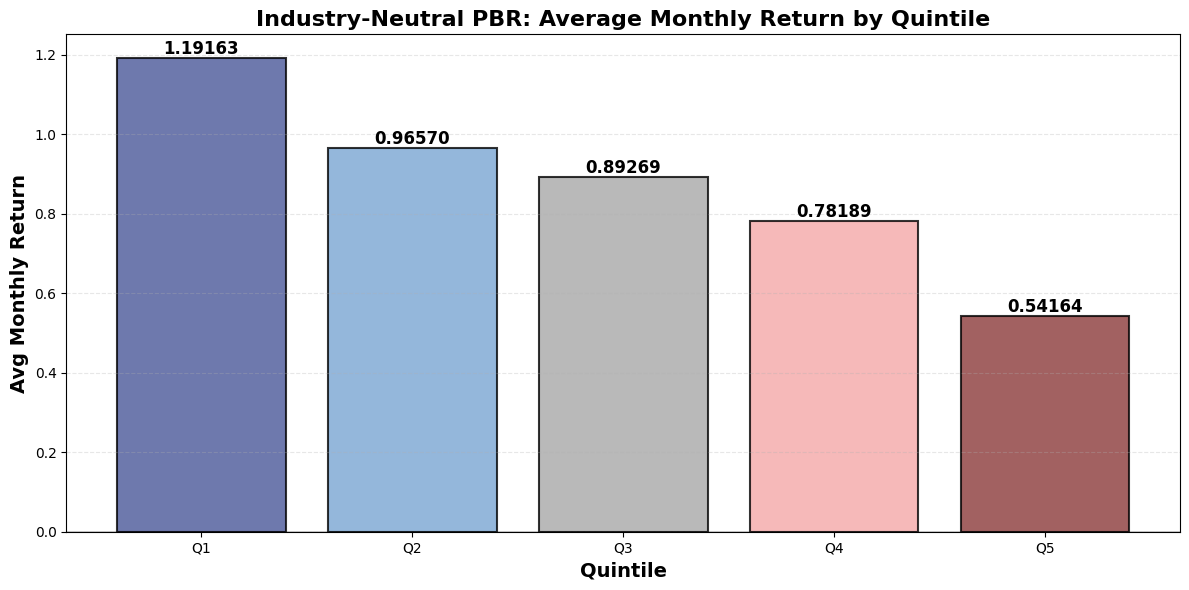


各分位の平均月次リターン（業種中立化）:
Q1: 1.19163 (119.163%)
Q2: 0.96570 (96.570%)
Q3: 0.89269 (89.269%)
Q4: 0.78189 (78.189%)
Q5: 0.54164 (54.164%)


In [ ]:
# 図1: 業種中立化 - 平均月次リターンのヒストグラム
plt.figure(figsize=(12, 6))

mean_returns_neutral = quintile_returns_neutral.mean()
colors = ['#4A5899', '#7AA5D2', '#A8A8A8', '#F4A8A8', '#8B3A3A']

bars = plt.bar(mean_returns_neutral.index, mean_returns_neutral.values,
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

plt.xlabel('Quintile', fontsize=14, fontweight='bold')
plt.ylabel('Avg Monthly Return', fontsize=14, fontweight='bold')
plt.title('Industry-Neutral PBR: Average Monthly Return by Quintile', fontsize=16, fontweight='bold')
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.grid(True, alpha=0.3, axis='y', linestyle='--')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.5f}', ha='center', va='bottom' if height > 0 else 'top',
            fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n各分位の平均月次リターン（業種中立化）:")
for q, ret in mean_returns_neutral.items():
    print(f"{q}: {ret:.5f} ({ret*100:.3f}%)")

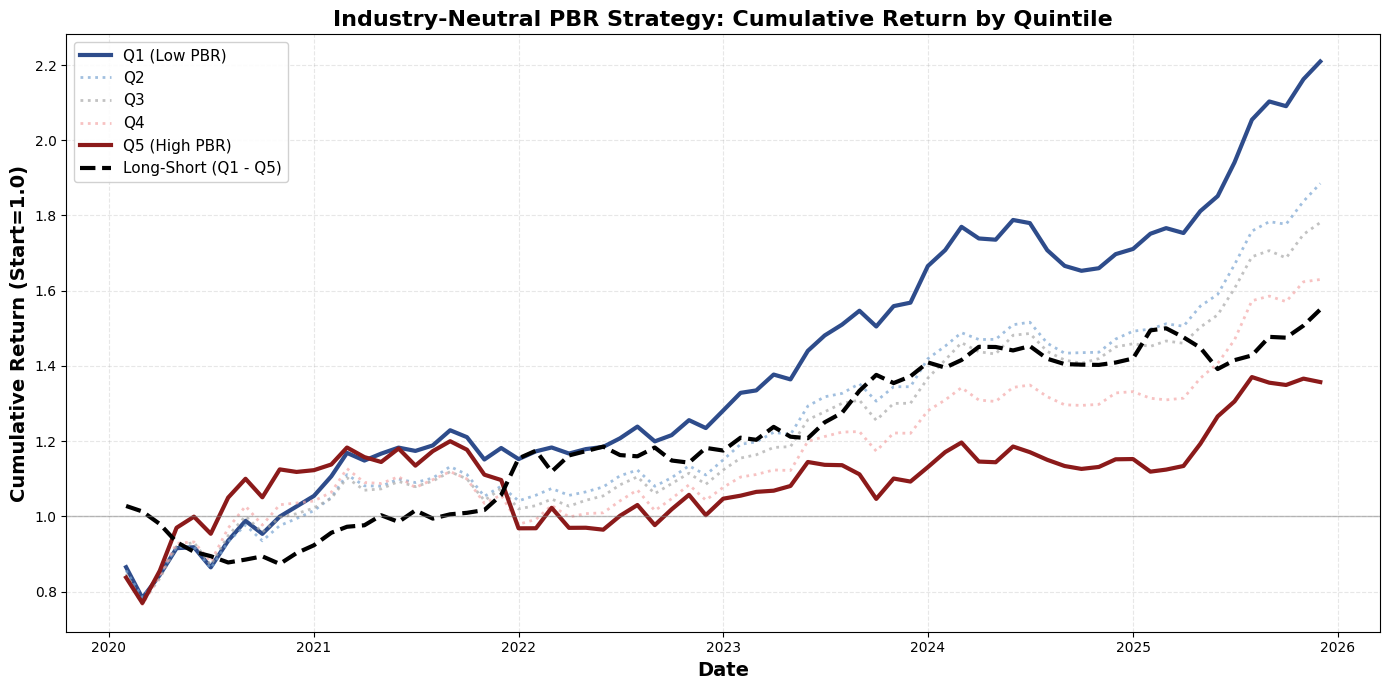


最終累積リターン（業種中立化、開始=1.0）:
Q1: 2.2095 (累積リターン: +120.95%)
Q2: 1.8852 (累積リターン: +88.52%)
Q3: 1.7813 (累積リターン: +78.13%)
Q4: 1.6298 (累積リターン: +62.98%)
Q5: 1.3570 (累積リターン: +35.70%)
Long-Short (Q1-Q5): 1.5501 (累積リターン: +55.01%)


In [ ]:
# 図2: 業種中立化 - 累積リターンの推移
plt.figure(figsize=(14, 7))

# 累積リターンを計算
cumulative_returns_neutral = (1 + quintile_returns_neutral / 100).cumprod()

# Long-Short ポートフォリオ
long_short_returns_neutral = quintile_returns_neutral['Q1'] - quintile_returns_neutral['Q5']
cumulative_long_short_neutral = (1 + long_short_returns_neutral / 100).cumprod()

# 日付インデックス
dates = pd.to_datetime(cumulative_returns_neutral.index, format='%Y/%m')

# プロット
plt.plot(dates, cumulative_returns_neutral['Q1'], linewidth=3, color='#2E4C8B',
         label='Q1 (Low PBR)', linestyle='-')
plt.plot(dates, cumulative_returns_neutral['Q2'], linewidth=2, color='#7AA5D2',
         label='Q2', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns_neutral['Q3'], linewidth=2, color='#A8A8A8',
         label='Q3', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns_neutral['Q4'], linewidth=2, color='#F4A8A8',
         label='Q4', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns_neutral['Q5'], linewidth=3, color='#8B1A1A',
         label='Q5 (High PBR)', linestyle='-')
plt.plot(dates, cumulative_long_short_neutral, linewidth=3, color='black',
         label='Long-Short (Q1 - Q5)', linestyle='--')

plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Return (Start=1.0)', fontsize=14, fontweight='bold')
plt.title('Industry-Neutral PBR Strategy: Cumulative Return by Quintile', fontsize=16, fontweight='bold')
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.axhline(y=1, color='gray', linestyle='-', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# 最終累積リターン
print("\n最終累積リターン（業種中立化、開始=1.0）:")
for col in cumulative_returns_neutral.columns:
    final_return = cumulative_returns_neutral[col].iloc[-1]
    total_return_pct = (final_return - 1) * 100
    print(f"{col}: {final_return:.4f} (累積リターン: {total_return_pct:+.2f}%)")

final_ls_neutral = cumulative_long_short_neutral.iloc[-1]
total_ls_pct_neutral = (final_ls_neutral - 1) * 100
print(f"Long-Short (Q1-Q5): {final_ls_neutral:.4f} (累積リターン: {total_ls_pct_neutral:+.2f}%)")

In [16]:
# 業種中立化バリュープレミアムの統計分析
value_premium_neutral = quintile_returns_neutral['Q1'] - quintile_returns_neutral['Q5']

print("\n" + "=" * 80)
print("業種中立化バリュープレミアム（Q1 - Q5）の統計分析")
print("=" * 80)
print(f"平均月次プレミアム: {value_premium_neutral.mean():.5f} ({value_premium_neutral.mean()*100:.3f}%)")
print(f"標準偏差: {value_premium_neutral.std():.5f}")
print(f"t値: {value_premium_neutral.mean() / (value_premium_neutral.std() / np.sqrt(len(value_premium_neutral))):.4f}")

# t検定
t_stat_neutral, p_value_neutral = stats.ttest_1samp(value_premium_neutral.dropna(), 0)
print(f"p値: {p_value_neutral:.6f}")

if p_value_neutral < 0.01:
    sig_neutral = '***'
elif p_value_neutral < 0.05:
    sig_neutral = '**'
elif p_value_neutral < 0.1:
    sig_neutral = '*'
else:
    sig_neutral = ''

print(f"有意性: {sig_neutral} ({'有意' if sig_neutral else '有意でない'})")
print(f"\n勝率（プレミアムが正の月）: {(value_premium_neutral > 0).sum() / len(value_premium_neutral) * 100:.2f}%")
print("=" * 80)


業種中立化バリュープレミアム（Q1 - Q5）の統計分析
平均月次プレミアム: 0.64999 (64.999%)
標準偏差: 2.50833
t値: 2.1835
p値: 0.032354
有意性: ** (有意)

勝率（プレミアムが正の月）: 57.75%


In [ ]:
# ===================================================================
# 業種平均対比PBR戦略
# ===================================================================

# 業種平均PBRに対する相対PBRによる5分位ポートフォリオ構築
def create_relative_pbr_quintile_portfolios(df_pbr, df_returns, df_industry, n_quintiles=5):
    """
    業種平均PBRに対する相対PBR（企業のPBR / 業種平均PBR）をシグナルとして
    全企業を対象に5分位ポートフォリオを構築

    シグナル: 相対PBR = 企業のPBR / 業種平均PBR
    - 相対PBRが低い（<1）: その業種の中でバリュー株
    - 相対PBRが高い（>1）: その業種の中でグロース株
    """
    pbr_cols = [col for col in df_pbr.columns if col != 'Company']
    return_cols = [col for col in df_returns.columns if col.startswith('ret_')]

    portfolio_returns = {f'Q{i+1}': [] for i in range(n_quintiles)}
    portfolio_returns['Date'] = []

    # 業種情報を取得
    industry_col = df_industry.columns[2]
    company_col = df_industry.columns[0]

    # 業種データを辞書として準備
    industry_dict = {}
    for idx, row in df_industry.iterrows():
        company_name = row[company_col]
        industry_name = row[industry_col]
        if company_name not in industry_dict and pd.notna(company_name):
            industry_dict[company_name] = industry_name

    for i in range(len(pbr_cols) - 1):
        formation_month = pbr_cols[i]
        return_month = return_cols[i]

        portfolio_returns['Date'].append(return_month.replace('ret_', ''))

        # PBR、リターン、業種をマージ
        temp_df = pd.DataFrame({
            'Company': df_pbr['Company'],
            'PBR': df_pbr[formation_month],
            'Return': df_returns[return_month]
        })

        # 企業名から業種情報をマッピング
        temp_df['Industry'] = temp_df['Company'].map(industry_dict)

        # 欠損値を除外
        temp_df = temp_df.dropna()

        if len(temp_df) < n_quintiles:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            continue

        # 業種ごとの平均PBRを計算
        industry_avg_pbr = temp_df.groupby('Industry')['PBR'].mean()

        # 各企業の相対PBR（企業PBR / 業種平均PBR）を計算
        temp_df['Relative_PBR'] = temp_df.apply(
            lambda row: row['PBR'] / industry_avg_pbr[row['Industry']]
            if row['Industry'] in industry_avg_pbr.index else np.nan,
            axis=1
        )

        # 相対PBRの欠損値を除外
        temp_df = temp_df.dropna(subset=['Relative_PBR'])

        if len(temp_df) < n_quintiles:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            continue

        # 相対PBRで全企業を5分位に分割
        try:
            temp_df['Quintile'] = pd.qcut(temp_df['Relative_PBR'], q=n_quintiles, labels=False, duplicates='drop')
        except Exception as e:
            for q in range(n_quintiles):
                portfolio_returns[f'Q{q+1}'].append(np.nan)
            continue

        # 各分位の等加重平均リターンを計算
        for q in range(n_quintiles):
            quintile_returns = temp_df[temp_df['Quintile'] == q]['Return']
            avg_return = quintile_returns.mean() if len(quintile_returns) > 0 else np.nan
            portfolio_returns[f'Q{q+1}'].append(avg_return)

    result_df = pd.DataFrame(portfolio_returns)
    result_df = result_df.set_index('Date')

    return result_df

# 相対PBR 5分位ポートフォリオを構築
quintile_returns_relative = create_relative_pbr_quintile_portfolios(
    df_pbr, df_returns, df_industry, n_quintiles=5
)

print("=" * 80)
print("業種平均対比PBR戦略の構築完了")
print("=" * 80)
print(f"期間: {quintile_returns_relative.index[0]} ～ {quintile_returns_relative.index[-1]}")
print(f"観測数: {len(quintile_returns_relative)}")
print(f"\n最初の10行:")
print(quintile_returns_relative.head(10))

業種平均対比PBR戦略の構築完了
期間: 2020/02 ～ 2025/12
観測数: 71

最初の10行:
                Q1         Q2         Q3         Q4         Q5
Date                                                          
2020/02 -14.069394 -14.296423 -15.288323 -15.505075 -16.548618
2020/03  -9.475458  -7.952313  -8.969687  -8.542870  -8.582172
2020/04   9.493235   8.259964   7.649101   8.236453  10.814673
2020/05   9.683274   9.780945   8.906206   9.736001  13.119823
2020/06   0.215694   0.891863   0.045296   0.547437   3.184774
2020/07  -6.440256  -6.019247  -5.910405  -5.803612  -4.615307
2020/08  10.413233   7.852098   8.229398   9.105656  10.087727
2020/09   6.285491   5.701999   4.922522   5.102632   4.624939
2020/10  -4.191196  -4.075439  -4.779024  -4.214778  -4.253260
2020/11   4.204573   4.575743   4.501936   5.275967   7.342788


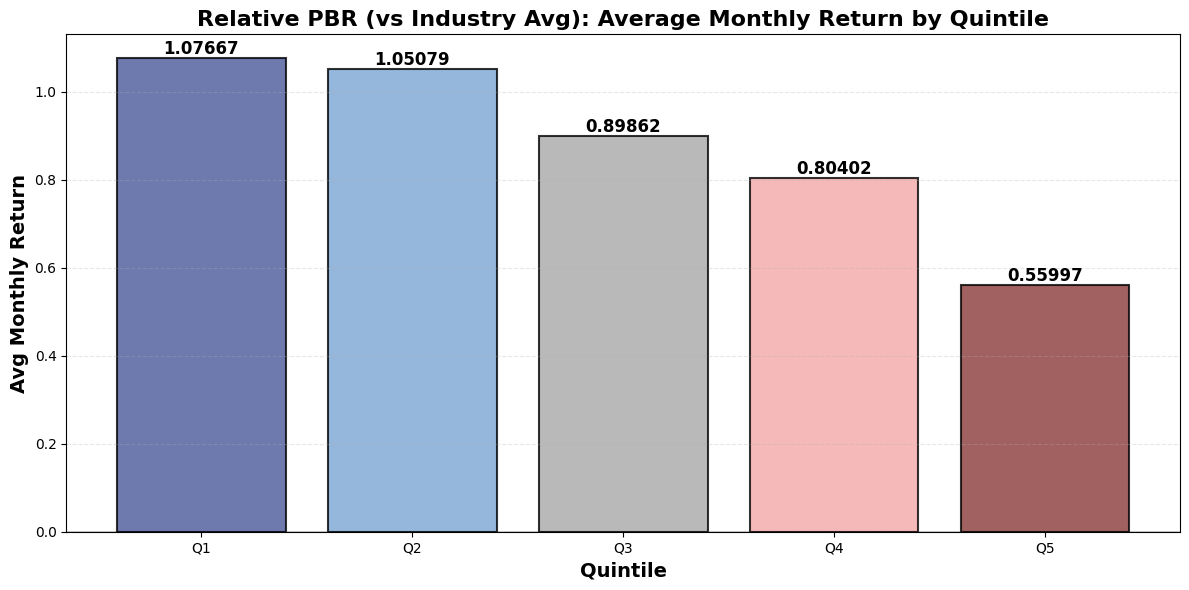


各分位の平均月次リターン（相対PBR戦略）:
Q1: 1.07667 (107.667%)
Q2: 1.05079 (105.079%)
Q3: 0.89862 (89.862%)
Q4: 0.80402 (80.402%)
Q5: 0.55997 (55.997%)


In [ ]:
# 図3: 相対PBR戦略 - 平均月次リターンのヒストグラム
plt.figure(figsize=(12, 6))

mean_returns_relative = quintile_returns_relative.mean()
colors = ['#4A5899', '#7AA5D2', '#A8A8A8', '#F4A8A8', '#8B3A3A']

bars = plt.bar(mean_returns_relative.index, mean_returns_relative.values,
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

plt.xlabel('Quintile', fontsize=14, fontweight='bold')
plt.ylabel('Avg Monthly Return', fontsize=14, fontweight='bold')
plt.title('Relative PBR (vs Industry Avg): Average Monthly Return by Quintile',
          fontsize=16, fontweight='bold')
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.grid(True, alpha=0.3, axis='y', linestyle='--')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.5f}', ha='center', va='bottom' if height > 0 else 'top',
            fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n各分位の平均月次リターン（相対PBR戦略）:")
for q, ret in mean_returns_relative.items():
    print(f"{q}: {ret:.5f} ({ret*100:.3f}%)")

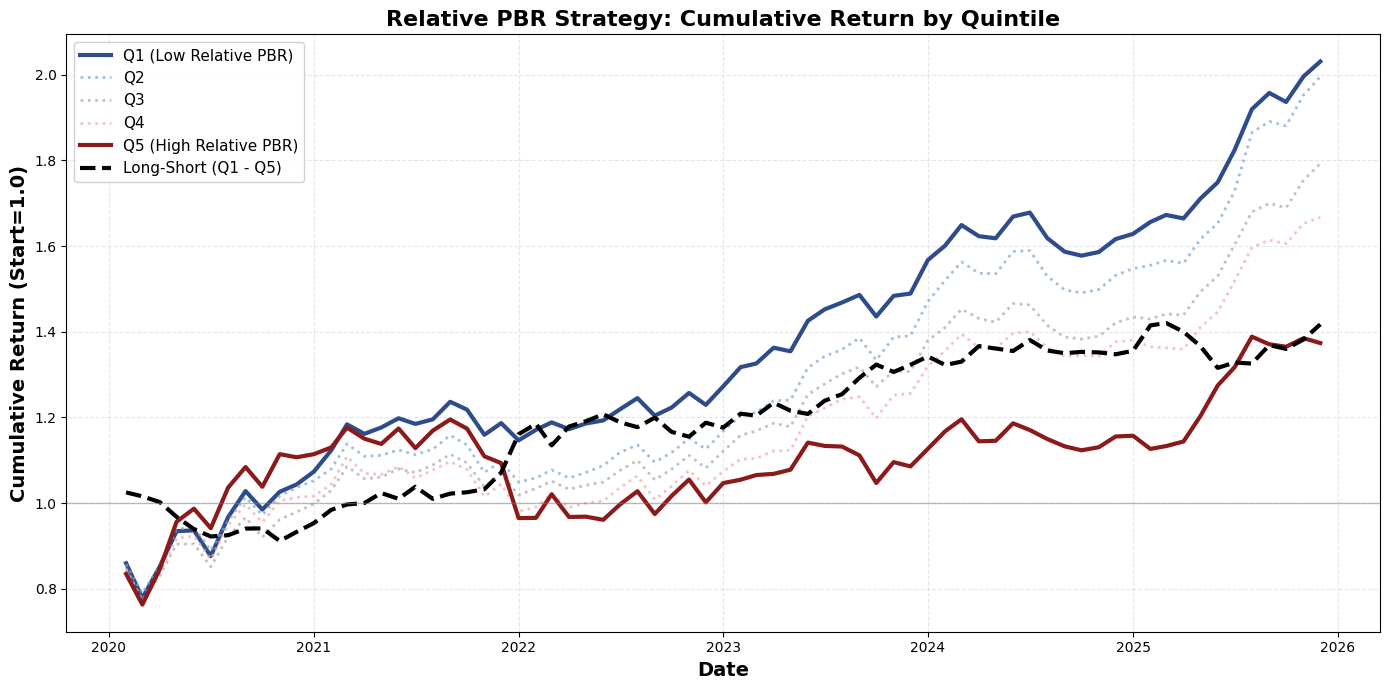


最終累積リターン（相対PBR戦略、開始=1.0）:
Q1: 2.0311 (累積リターン: +103.11%)
Q2: 1.9958 (累積リターン: +99.58%)
Q3: 1.7925 (累積リターン: +79.25%)
Q4: 1.6669 (累積リターン: +66.69%)
Q5: 1.3737 (累積リターン: +37.37%)
Long-Short (Q1-Q5): 1.4173 (累積リターン: +41.73%)


In [ ]:
# 図4: 相対PBR戦略 - 累積リターンの推移
plt.figure(figsize=(14, 7))

# 累積リターンを計算
cumulative_returns_relative = (1 + quintile_returns_relative / 100).cumprod()

# Long-Short ポートフォリオ
long_short_returns_relative = quintile_returns_relative['Q1'] - quintile_returns_relative['Q5']
cumulative_long_short_relative = (1 + long_short_returns_relative / 100).cumprod()

# 日付インデックス
dates = pd.to_datetime(cumulative_returns_relative.index, format='%Y/%m')

# プロット
plt.plot(dates, cumulative_returns_relative['Q1'], linewidth=3, color='#2E4C8B',
         label='Q1 (Low Relative PBR)', linestyle='-')
plt.plot(dates, cumulative_returns_relative['Q2'], linewidth=2, color='#7AA5D2',
         label='Q2', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns_relative['Q3'], linewidth=2, color='#A8A8A8',
         label='Q3', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns_relative['Q4'], linewidth=2, color='#F4A8A8',
         label='Q4', linestyle=':', alpha=0.7)
plt.plot(dates, cumulative_returns_relative['Q5'], linewidth=3, color='#8B1A1A',
         label='Q5 (High Relative PBR)', linestyle='-')
plt.plot(dates, cumulative_long_short_relative, linewidth=3, color='black',
         label='Long-Short (Q1 - Q5)', linestyle='--')

plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Return (Start=1.0)', fontsize=14, fontweight='bold')
plt.title('Relative PBR Strategy: Cumulative Return by Quintile', fontsize=16, fontweight='bold')
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.axhline(y=1, color='gray', linestyle='-', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# 最終累積リターン
print("\n最終累積リターン（相対PBR戦略、開始=1.0）:")
for col in cumulative_returns_relative.columns:
    final_return = cumulative_returns_relative[col].iloc[-1]
    total_return_pct = (final_return - 1) * 100
    print(f"{col}: {final_return:.4f} (累積リターン: {total_return_pct:+.2f}%)")

final_ls_relative = cumulative_long_short_relative.iloc[-1]
total_ls_pct_relative = (final_ls_relative - 1) * 100
print(f"Long-Short (Q1-Q5): {final_ls_relative:.4f} (累積リターン: {total_ls_pct_relative:+.2f}%)")

In [22]:
# 相対PBR戦略のバリュープレミアム統計分析
value_premium_relative = quintile_returns_relative['Q1'] - quintile_returns_relative['Q5']

print("\n" + "=" * 80)
print("相対PBR戦略のバリュープレミアム（Q1 - Q5）の統計分析")
print("=" * 80)
print(f"平均月次プレミアム: {value_premium_relative.mean():.5f} ({value_premium_relative.mean()*100:.3f}%)")
print(f"標準偏差: {value_premium_relative.std():.5f}")
print(f"t値: {value_premium_relative.mean() / (value_premium_relative.std() / np.sqrt(len(value_premium_relative))):.4f}")

# t検定
t_stat_relative, p_value_relative = stats.ttest_1samp(value_premium_relative.dropna(), 0)
print(f"p値: {p_value_relative:.6f}")

if p_value_relative < 0.01:
    sig_relative = '***'
elif p_value_relative < 0.05:
    sig_relative = '**'
elif p_value_relative < 0.1:
    sig_relative = '*'
else:
    sig_relative = ''

print(f"有意性: {sig_relative} ({'有意' if sig_relative else '有意でない'})")
print(f"\n勝率（プレミアムが正の月）: {(value_premium_relative > 0).sum() / len(value_premium_relative) * 100:.2f}%")
print("=" * 80)


相対PBR戦略のバリュープレミアム（Q1 - Q5）の統計分析
平均月次プレミアム: 0.51670 (51.670%)
標準偏差: 2.22877
t値: 1.9534
p値: 0.054766
有意性: * (有意)

勝率（プレミアムが正の月）: 57.75%


In [23]:
# 3つの戦略の比較サマリー
print("\n" + "=" * 80)
print("3つの戦略の比較サマリー")
print("=" * 80)

# 業種内5分位戦略のデータ（既に計算済み）
vp_neutral_mean = value_premium_neutral.mean()
vp_neutral_std = value_premium_neutral.std()
vp_neutral_t = vp_neutral_mean / (vp_neutral_std / np.sqrt(len(value_premium_neutral)))
vp_neutral_p = p_value_neutral

# 相対PBR戦略のデータ
vp_relative_mean = value_premium_relative.mean()
vp_relative_std = value_premium_relative.std()
vp_relative_t = vp_relative_mean / (vp_relative_std / np.sqrt(len(value_premium_relative)))
vp_relative_p = p_value_relative

comparison_df = pd.DataFrame({
    '戦略': ['業種内5分位戦略', '相対PBR戦略'],
    '平均月次プレミアム (%)': [vp_neutral_mean * 100, vp_relative_mean * 100],
    '年率プレミアム (%)': [vp_neutral_mean * 12 * 100, vp_relative_mean * 12 * 100],
    '標準偏差': [vp_neutral_std, vp_relative_std],
    't値': [vp_neutral_t, vp_relative_t],
    'p値': [vp_neutral_p, vp_relative_p],
    '有意性': [
        '**' if vp_neutral_p < 0.05 else ('*' if vp_neutral_p < 0.1 else ''),
        '**' if vp_relative_p < 0.05 else ('*' if vp_relative_p < 0.1 else '')
    ],
    '勝率 (%)': [
        (value_premium_neutral > 0).sum() / len(value_premium_neutral) * 100,
        (value_premium_relative > 0).sum() / len(value_premium_relative) * 100
    ]
})

print("\n")
print(comparison_df.to_string(index=False))
print("\n")
print("注: *** p<0.01, ** p<0.05, * p<0.1")
print("=" * 80)

# 解釈
print("\n【解釈】")
print("-" * 80)
print("1. 業種内5分位戦略:")
print("   - 各業種内で独立にPBRで5分位に分割し、業種を跨いで同じ分位を平均化")
print("   - 業種要因を完全に除去したバリュー効果を検証")
print()
print("2. 相対PBR戦略:")
print("   - 各企業のPBRを業種平均PBRで割った相対PBRをシグナルとして使用")
print("   - 全企業を相対PBRで5分位に分割")
print("   - 業種要因を調整しつつ、全市場でのポートフォリオ構築")
print("=" * 80)


3つの戦略の比較サマリー


      戦略  平均月次プレミアム (%)  年率プレミアム (%)     標準偏差       t値       p値 有意性    勝率 (%)
業種内5分位戦略      64.999089   779.989070 2.508332 2.183491 0.032354  ** 57.746479
 相対PBR戦略      51.669630   620.035564 2.228772 1.953435 0.054766   * 57.746479


注: *** p<0.01, ** p<0.05, * p<0.1

【解釈】
--------------------------------------------------------------------------------
1. 業種内5分位戦略:
   - 各業種内で独立にPBRで5分位に分割し、業種を跨いで同じ分位を平均化
   - 業種要因を完全に除去したバリュー効果を検証

2. 相対PBR戦略:
   - 各企業のPBRを業種平均PBRで割った相対PBRをシグナルとして使用
   - 全企業を相対PBRで5分位に分割
   - 業種要因を調整しつつ、全市場でのポートフォリオ構築


In [24]:
# ===================================================================
# シャープレシオの計算
# ===================================================================

print("\n" + "=" * 80)
print("シャープレシオの計算（リスクフリーレート = 0と仮定）")
print("=" * 80)

# 1. 業種内5分位戦略のシャープレシオ
print("\n【1. 業種内5分位戦略】")
print("-" * 80)

sharpe_ratios_neutral = {}
for col in quintile_returns_neutral.columns:
    mean_return = quintile_returns_neutral[col].mean()
    std_return = quintile_returns_neutral[col].std()
    sharpe_monthly = mean_return / std_return if std_return > 0 else 0
    sharpe_annual = sharpe_monthly * np.sqrt(12)
    sharpe_ratios_neutral[col] = {
        '月次': sharpe_monthly,
        '年率換算': sharpe_annual
    }

# Long-Short戦略
ls_neutral_mean = value_premium_neutral.mean()
ls_neutral_std = value_premium_neutral.std()
ls_neutral_sharpe_monthly = ls_neutral_mean / ls_neutral_std if ls_neutral_std > 0 else 0
ls_neutral_sharpe_annual = ls_neutral_sharpe_monthly * np.sqrt(12)

sharpe_ratios_neutral['Long-Short (Q1-Q5)'] = {
    '月次': ls_neutral_sharpe_monthly,
    '年率換算': ls_neutral_sharpe_annual
}

sharpe_df_neutral = pd.DataFrame(sharpe_ratios_neutral).T
print("\nシャープレシオ:")
print(sharpe_df_neutral.to_string())

# 2. 相対PBR戦略のシャープレシオ
print("\n" + "-" * 80)
print("【2. 相対PBR戦略】")
print("-" * 80)

sharpe_ratios_relative = {}
for col in quintile_returns_relative.columns:
    mean_return = quintile_returns_relative[col].mean()
    std_return = quintile_returns_relative[col].std()
    sharpe_monthly = mean_return / std_return if std_return > 0 else 0
    sharpe_annual = sharpe_monthly * np.sqrt(12)
    sharpe_ratios_relative[col] = {
        '月次': sharpe_monthly,
        '年率換算': sharpe_annual
    }

# Long-Short戦略
ls_relative_mean = value_premium_relative.mean()
ls_relative_std = value_premium_relative.std()
ls_relative_sharpe_monthly = ls_relative_mean / ls_relative_std if ls_relative_std > 0 else 0
ls_relative_sharpe_annual = ls_relative_sharpe_monthly * np.sqrt(12)

sharpe_ratios_relative['Long-Short (Q1-Q5)'] = {
    '月次': ls_relative_sharpe_monthly,
    '年率換算': ls_relative_sharpe_annual
}

sharpe_df_relative = pd.DataFrame(sharpe_ratios_relative).T
print("\nシャープレシオ:")
print(sharpe_df_relative.to_string())

# 3. Long-Short戦略の比較
print("\n" + "=" * 80)
print("Long-Short戦略のシャープレシオ比較")
print("=" * 80)

comparison_sharpe = pd.DataFrame({
    '戦略': ['業種内5分位戦略', '相対PBR戦略'],
    '月次シャープレシオ': [ls_neutral_sharpe_monthly, ls_relative_sharpe_monthly],
    '年率換算シャープレシオ': [ls_neutral_sharpe_annual, ls_relative_sharpe_annual]
})

print("\n")
print(comparison_sharpe.to_string(index=False))

print("\n" + "=" * 80)
print("解釈:")
print("-" * 80)
print("- シャープレシオ = 平均リターン / リターンの標準偏差")
print("- リスク調整後のパフォーマンスを測定")
print("- 一般的に、シャープレシオ > 1 は良好、> 2 は優秀とされる")
print("- 年率換算 = 月次シャープレシオ × sqrt(12)")
print("=" * 80)


シャープレシオの計算（リスクフリーレート = 0と仮定）

【1. 業種内5分位戦略】
--------------------------------------------------------------------------------

シャープレシオ:
                          月次      年率換算
Q1                  0.321906  1.115117
Q2                  0.261443  0.905665
Q3                  0.229551  0.795189
Q4                  0.183104  0.634290
Q5                  0.115072  0.398621
Long-Short (Q1-Q5)  0.259133  0.897662

--------------------------------------------------------------------------------
【2. 相対PBR戦略】
--------------------------------------------------------------------------------

シャープレシオ:
                          月次      年率換算
Q1                  0.280504  0.971695
Q2                  0.275714  0.955101
Q3                  0.236116  0.817932
Q4                  0.199397  0.690730
Q5                  0.118504  0.410510
Long-Short (Q1-Q5)  0.231830  0.803083

Long-Short戦略のシャープレシオ比較


      戦略  月次シャープレシオ  年率換算シャープレシオ
業種内5分位戦略   0.259133     0.897662
 相対PBR戦略   0.231830     0.803083

解釈:
--